# Simple but Effective Allergy Classification

Quick implementation of effective methods for allergy prediction using genus + metabolite data.

In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns

print("Libraries loaded!")

Libraries loaded!


## 1. Load Processed Data

In [7]:
# Load the processed data from previous notebook
try:
    combined_data = pd.read_excel('processed_combined_genus_metabolite203.xlsx', index_col=0)
    print(f"Data loaded: {combined_data.shape}")
except:
    print("Please run the data processing notebook first!")
    # Alternative: load from individual files
    X = pd.read_excel('processed_features_genus_metabolite203.xlsx', index_col=0)
    labels_df = pd.read_excel('processed_labels_genus_metabolite203.xlsx')
    y = labels_df['label'].values
    
# Separate features and labels
X = combined_data.drop(['label', 'group'], axis=1)
y = combined_data['label']

# Fix column names - remove special characters that XGBoost doesn't like
def clean_column_names(df):
    """Clean column names to be compatible with XGBoost"""
    df = df.copy()
    # Replace problematic characters
    df.columns = df.columns.str.replace('[', '', regex=False)
    df.columns = df.columns.str.replace(']', '', regex=False)
    df.columns = df.columns.str.replace('<', '_lt_', regex=False)
    df.columns = df.columns.str.replace('>', '_gt_', regex=False)
    df.columns = df.columns.str.replace('(', '_', regex=False)
    df.columns = df.columns.str.replace(')', '_', regex=False)
    df.columns = df.columns.str.replace(' ', '_', regex=False)
    df.columns = df.columns.str.replace('-', '_', regex=False)
    df.columns = df.columns.str.replace('/', '_', regex=False)
    df.columns = df.columns.str.replace('\\', '_', regex=False)
    # Remove multiple underscores
    df.columns = df.columns.str.replace('_+', '_', regex=True)
    # Remove leading/trailing underscores
    df.columns = df.columns.str.strip('_')
    return df

X = clean_column_names(X)

print(f"Features: {X.shape}")
print(f"Labels: {y.value_counts()}")
print(f"Sample column names: {list(X.columns[:5])}")
print(f"Cleaned problematic names: {[col for col in X.columns if 'Ruminococcus' in col][:3]}")

Data loaded: (160, 6693)
Features: (160, 6691)
Labels: label
0    88
1    72
Name: count, dtype: int64
Sample column names: ['genus_Escherichia_Shigella', 'genus_Bifidobacterium', 'genus_Klebsiella', 'genus_Bacteroides', 'genus_Clostridium_sensu_stricto_1']
Cleaned problematic names: ['genus_Ruminococcus_gnavus_group', 'genus_Ruminococcus_torques_group', 'genus_Ruminococcus']


## 2. Quick Baseline Models

In [8]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Define models
models = {
    'XGBoost': XGBClassifier(n_estimators=100, max_depth=6, learning_rate=0.1, random_state=42),
    'LightGBM': LGBMClassifier(n_estimators=100, max_depth=6, learning_rate=0.1, random_state=42, verbose=-1),
    'RandomForest': RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
}

# Train and evaluate
results = {}
for name, model in models.items():
    # Cross-validation on training set
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='roc_auc')
    
    # Train on full training set and test
    model.fit(X_train, y_train)
    test_pred = model.predict_proba(X_test)[:, 1]
    test_auc = roc_auc_score(y_test, test_pred)
    
    results[name] = {
        'CV_AUC': cv_scores.mean(),
        'CV_std': cv_scores.std(),
        'Test_AUC': test_auc
    }
    
    print(f"{name}:")
    print(f"  CV AUC: {cv_scores.mean():.3f} ± {cv_scores.std():.3f}")
    print(f"  Test AUC: {test_auc:.3f}")
    print()

XGBoost:
  CV AUC: 0.881 ± 0.059
  Test AUC: 0.849

LightGBM:
  CV AUC: 0.861 ± 0.068
  Test AUC: 0.837

RandomForest:
  CV AUC: 0.718 ± 0.086
  Test AUC: 0.873



## 3. Multi-Modal Approach (Simple)

In [13]:
# Separate genus and metabolite features
genus_features = [col for col in X.columns if col.startswith('genus_')]
metabolite_features = [col for col in X.columns if col.startswith('metabolite_')]

print(f"Genus features: {len(genus_features)}")
print(f"Metabolite features: {len(metabolite_features)}")

# Train separate models
genus_model = XGBClassifier(n_estimators=100, max_depth=6, random_state=42)
metabolite_model = XGBClassifier(n_estimators=100, max_depth=6, random_state=42)

genus_model.fit(X_train[genus_features], y_train)
metabolite_model.fit(X_train[metabolite_features], y_train)

# Get predictions
genus_pred = genus_model.predict_proba(X_test[genus_features])[:, 1]
metabolite_pred = metabolite_model.predict_proba(X_test[metabolite_features])[:, 1]

# Simple ensemble - average predictions
ensemble_pred = (genus_pred + metabolite_pred) / 2

# Evaluate
genus_auc = roc_auc_score(y_test, genus_pred)
metabolite_auc = roc_auc_score(y_test, metabolite_pred)
ensemble_auc = roc_auc_score(y_test, ensemble_pred)

print(f"Genus only AUC: {genus_auc:.3f}")
print(f"Metabolite only AUC: {metabolite_auc:.3f}")
print(f"Ensemble AUC: {ensemble_auc:.3f}")

Genus features: 567
Metabolite features: 6124
Genus only AUC: 0.901
Metabolite only AUC: 0.845
Ensemble AUC: 0.889


## 4. Feature Selection

In [15]:
# Select top features
n_features = min(50, X.shape[1] // 2)  # Select top 50 or half of features
selector = SelectKBest(f_classif, k=n_features)
X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)

# Train model on selected features
model_selected = XGBClassifier(n_estimators=100, max_depth=6, random_state=42)
model_selected.fit(X_train_selected, y_train)

# Evaluate
pred_selected = model_selected.predict_proba(X_test_selected)[:, 1]
auc_selected = roc_auc_score(y_test, pred_selected)

print(f"Selected features AUC: {auc_selected:.3f}")
print(f"Number of features used: {n_features}")

# Show top features
feature_scores = selector.scores_
feature_names = X.columns
top_features = pd.DataFrame({
    'feature': feature_names,
    'score': feature_scores
}).sort_values('score', ascending=False).head(10)

print("\nTop 10 features:")
print(top_features)

Selected features AUC: 0.798
Number of features used: 50

Top 10 features:
                    feature       score
1     genus_Bifidobacterium  104.394833
5222   metabolite_FT05049PR   26.490208
4727   metabolite_FT14424PR   26.026333
2238   metabolite_FT05881NR   23.374477
1817   metabolite_FT07784PR   22.830455
6476   metabolite_FT06943PR   22.822147
2108   metabolite_FT10404PR   22.806093
6546   metabolite_FT06820NR   22.476568
5999   metabolite_FT05544NR   21.954232
4703   metabolite_FT05287PR   21.131786


c:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:110: UserWarning: Features [114 135 137 140 148 156 171 182 194 195 206 208 219 227 229 236 237 243
 246 250 251 256 263 270 272 275 282 289 290 294 299 300 302 306 310 313
 314 316 319 321 322 328 329 330 332 334 337 341 343 346 349 351 354 356
 359 360 362 370 371 374 378 379 381 382 388 391 392 398 399 405 406 407
 408 409 411 412 413 415 416 417 419 420 421 422 424 426 427 428 430 432
 433 434 437 439 441 442 445 446 447 448 450 451 454 455 459 461 462 463
 464 470 473 475 476 477 478 479 480 481 482 483 484 485 486 487 488 492
 493 494 495 497 499 500 501 502 503 504 505 506 507 508 509 510 511 516
 517 518 519 520 523 525 526 528 532 533 534 537 538 539 544 546 547 548
 551 554 555 556 557 558 559 560 561 563 565 566] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
c:\Users\admin\AppData\Local\Programs\Python\P

## 5. Best Model Analysis

Best method: Genus_Only
Best AUC: 0.901


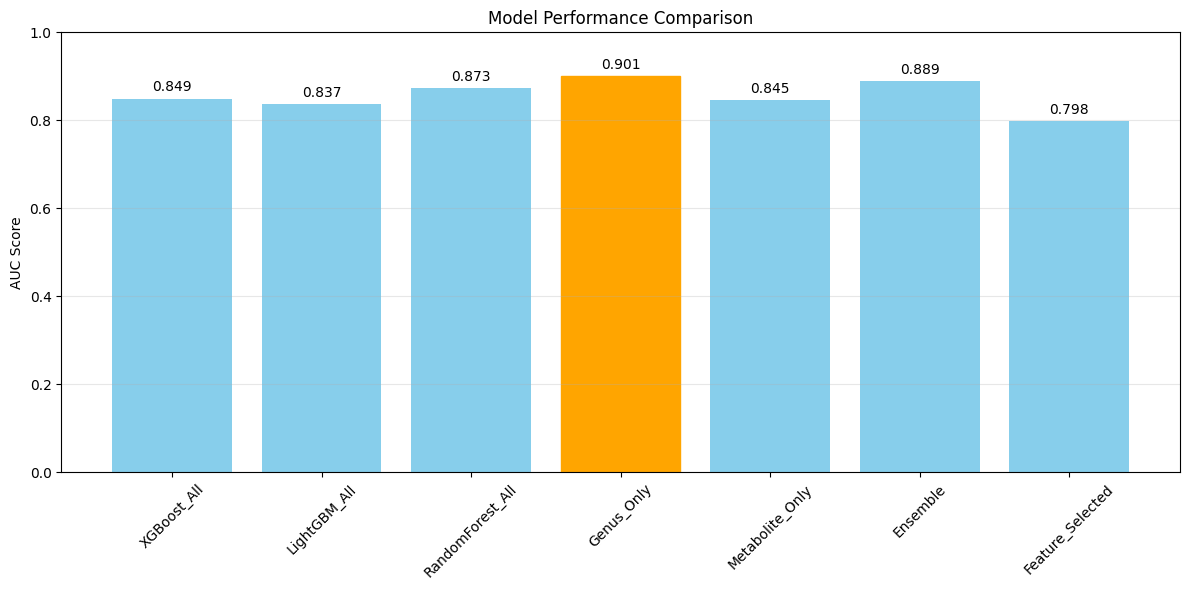

In [16]:
# Find best performing approach
all_results = {
    'XGBoost_All': results['XGBoost']['Test_AUC'],
    'LightGBM_All': results['LightGBM']['Test_AUC'],
    'RandomForest_All': results['RandomForest']['Test_AUC'],
    'Genus_Only': genus_auc,
    'Metabolite_Only': metabolite_auc,
    'Ensemble': ensemble_auc,
    'Feature_Selected': auc_selected
}

best_method = max(all_results, key=all_results.get)
best_score = all_results[best_method]

print(f"Best method: {best_method}")
print(f"Best AUC: {best_score:.3f}")

# Plot results
plt.figure(figsize=(12, 6))
methods = list(all_results.keys())
scores = list(all_results.values())

bars = plt.bar(methods, scores, color='skyblue')
bars[methods.index(best_method)].set_color('orange')  # Highlight best

plt.title('Model Performance Comparison')
plt.ylabel('AUC Score')
plt.xticks(rotation=45)
plt.ylim(0, 1)
plt.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar, score in zip(bars, scores):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
             f'{score:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

## 6. Final Model and Predictions

Using Genus_Only

Final Model Performance:
AUC: 0.873

Classification Report:
              precision    recall  f1-score   support

           N       0.70      0.89      0.78        18
         IgE       0.78      0.50      0.61        14

    accuracy                           0.72        32
   macro avg       0.74      0.69      0.69        32
weighted avg       0.73      0.72      0.71        32



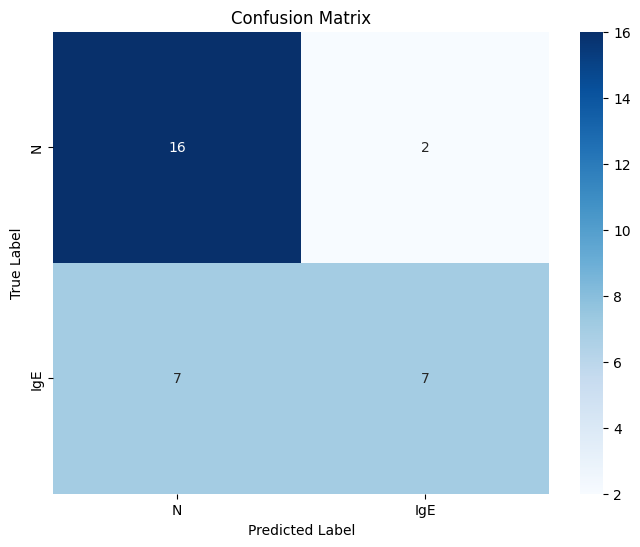


Model successfully trained and evaluated!
Best approach: Genus_Only with AUC = 0.901


In [17]:
# Use the best performing model
if best_method == 'Ensemble':
    final_predictions = ensemble_pred
    print("Using ensemble of genus + metabolite models")
elif best_method == 'Feature_Selected':
    final_predictions = pred_selected
    print(f"Using feature selection with {n_features} features")
else:
    # Retrain the best single model
    if 'XGBoost' in best_method:
        final_model = XGBClassifier(n_estimators=100, max_depth=6, random_state=42)
    elif 'LightGBM' in best_method:
        final_model = LGBMClassifier(n_estimators=100, max_depth=6, random_state=42, verbose=-1)
    else:
        final_model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
    
    final_model.fit(X_train, y_train)
    final_predictions = final_model.predict_proba(X_test)[:, 1]
    print(f"Using {best_method}")

# Convert probabilities to binary predictions
binary_predictions = (final_predictions > 0.5).astype(int)

# Detailed evaluation
print(f"\nFinal Model Performance:")
print(f"AUC: {roc_auc_score(y_test, final_predictions):.3f}")
print("\nClassification Report:")
print(classification_report(y_test, binary_predictions, target_names=['N', 'IgE']))

# Confusion Matrix
cm = confusion_matrix(y_test, binary_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['N', 'IgE'], yticklabels=['N', 'IgE'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

print(f"\nModel successfully trained and evaluated!")
print(f"Best approach: {best_method} with AUC = {best_score:.3f}")